In [196]:
import pandas as pd
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt

In [236]:
przystanki=pd.read_csv('all_stops.csv', error_bad_lines=False)
przystanki.head()
#przystanki.loc[przystanki.ID==410804]

,ID,STREET_NAME,X,Y,BUS_TRAM_NO
0,100101,"Ul./Pl.: Targowa,",21.044827,52.248455,"['123', '125', '138', '146', '147', '166', '20..."
1,100102,"Ul./Pl.: Targowa,",21.044443,52.249078,"['138', '166', '509', 'N21', '509^']"
2,100103,"Ul./Pl.: Targowa,",21.043983,52.248998,"['3', '6', '7', '9^', '22^', '24^', '25', '26']"
3,100104,"Ul./Pl.: Targowa,",21.041726,52.249905,"['3', '6', '13', '20^', '23^', '25', '26', '28']"
4,100106,"Ul./Pl.: Kijowska,",21.043710,52.250008,"['3^', '6^', '7', '9^', '13', '20^', '22^', '2..."


In [201]:
# merge po ID i FROM potem groupby po LINE_NUMBER potem magia, numery linii na inty jeśli się da może try catch na inta i jeśli mniejszy niż 100 to tramwaj
linie=pd.read_csv('all_lines.csv', error_bad_lines=False)
linie.head()


,LINE_NUMBER,FROM,TO,FROM_STREET_NAME,TO_STREET_NAME
0,1,410804,410803,"Banacha,","Banacha,"
1,1,410803,400503,"Banacha,","Bitwy Warszawskiej 1920 r.,"
2,1,400503,400403,"Bitwy Warszawskiej 1920 r.,","Och-Teatr,"
3,1,400403,412103,"Och-Teatr,","Wawelska,"
4,1,412103,400307,"Wawelska,","pl.Narutowicza,"


In [204]:
ztm=linie.merge(przystanki[['ID','X','Y']], left_on='FROM', right_on='ID')
ztm['gps'] = list(zip(ztm.X, ztm.Y))
ztm.head()
for z in ztm:    
    ztm.LINE_NUMBER=pd.to_numeric(ztm.LINE_NUMBER, errors='coerce')
ztm_trams=ztm.loc[ztm.LINE_NUMBER<100]
ztm_bus=ztm.loc[(ztm.LINE_NUMBER>100)]

In [228]:
#ztm_trams[['ID','gps']].to_dict()
#trams_dict=ztm_trams[['ID','gps']].set_index('ID').T.apply(tuple).to_dict()
trams_dict=ztm_trams.set_index('ID')[['X', 'Y']].T.apply(tuple).to_dict()
buses_dict=ztm_bus.set_index('ID')[['X', 'Y']].T.apply(tuple).to_dict()

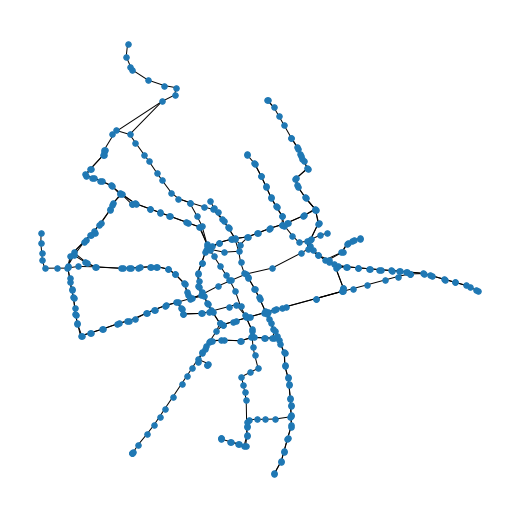

In [216]:
#ztm_trams=ztm_trams[ztm_trams.TO!=108703]
trams = nx.DiGraph()
# t1=ztm.iloc[1:2,:]
# t2=ztm.iloc[21:22,:]
# t2

# #trams.add_node('Banacha',pos=(t1.X,t1.Y))
# #trams.add_node('Narutowicza',pos=(t2.X.iloc[0],t2.Y.iloc[0]))
# #trams.add_edge('Banacha','Narutowicza')
# #pos=nx.get_node_attributes(trams,'pos')
# #nx.draw(trams,pos)

# pos
# t1['X'].iloc[0]
# ztm_trams.head()


trams.add_nodes_from(trams_dict.keys())

src=ztm_trams.loc[(ztm_trams.FROM.isin(ztm_trams.ID)) ,'FROM']
dst=ztm_trams.loc[(ztm_trams.TO.isin(ztm_trams.ID)) ,'TO']
ztm_trams_filtered=ztm_trams[(ztm_trams["TO"].isin(dst.values) & ztm_trams['FROM'].isin(src.values))]

trams.add_edges_from(list(zip(ztm_trams_filtered['FROM'].values, ztm_trams_filtered['TO'].values)))
# for k, v in trams_dict.items():
#     trams.add_edges_from(([(k, t) for t in v]))


# pos=nx.get_node_attributes(trams,'pos')
# pos

for n, p in trams_dict.items():
    trams.nodes[n]['pos'] = p

#trams1=nx.DiGraph(trams_dict)
plt.figure(figsize=(7, 7))
nx.draw(trams,trams_dict,node_size=30, arrows=False)
plt.show()

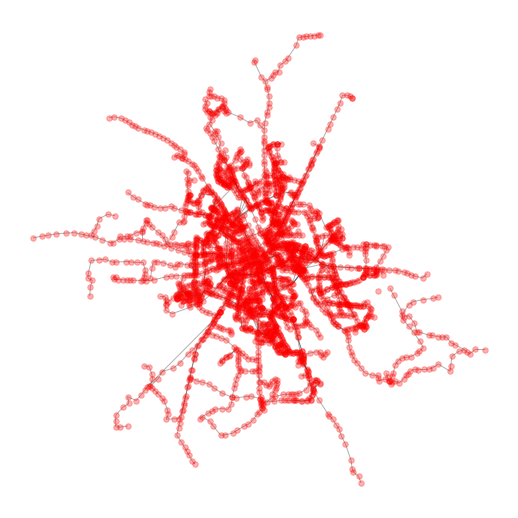

In [235]:
buses = nx.DiGraph()

buses.add_nodes_from(buses_dict.keys())
src=ztm_bus.loc[(ztm_bus.FROM.isin(ztm_bus.ID)) ,'FROM']
dst=ztm_bus.loc[(ztm_bus.TO.isin(ztm_bus.ID)) ,'TO']
ztm_bus_filtered=ztm_bus[(ztm_bus["TO"].isin(dst.values) & ztm_bus['FROM'].isin(src.values))]

buses.add_edges_from(list(zip(ztm_bus_filtered['FROM'].values, ztm_bus_filtered['TO'].values)))

for n, p in buses_dict.items():
    buses.nodes[n]['pos'] = p

#trams1=nx.DiGraph(trams_dict)
plt.figure(figsize=(7, 7))
nx.draw(buses,buses_dict,node_size=30, arrows=False, node_color='red', alpha=.3)
plt.show()


# charakterystyki

zarjrzeć do poprzednich prac

# zad 6

In [227]:
#src=ztm_bus.loc[ztm_bus.FROM.isin(ztm_bus.ID) ,'FROM']
#src=ztm_trams.loc[(ztm_trams.FROM.isin(ztm_trams.ID)) ,'FROM']
#ztm_bus[ztm_bus.ID==107702]
ztm_bus.head()

,LINE_NUMBER,FROM,TO,FROM_STREET_NAME,TO_STREET_NAME,ID,X,Y,gps
156,169.0,107102,107702,"Bródnowska,","rondo Żaba,",107102,21.038481,52.264222,"(21.038481, 52.264222)"
182,135.0,107101,129201,"Bródnowska,","Szymanowskiego,",107101,21.038261,52.263766,"(21.038261, 52.263766)"
190,160.0,100303,116301,"Dw.Wileński,","Park Praski,",100303,21.033248,52.254118,"(21.033248, 52.254118)"
191,190.0,100303,116301,"Dw.Wileński,","Park Praski,",100303,21.033248,52.254118,"(21.033248, 52.254118)"
197,160.0,116301,704702,"Park Praski,","Stare Miasto,",116301,21.029576,52.252548,"(21.029576000000002, 52.252548)"


In [189]:
#ztm_trams=ztm_trams[ztm_trams.TO!=108702]
107702 
#ztm_trams.loc[ztm_trams.ID==108702]
#ztm_trams['FROM'].iloc()[0]
src=ztm_trams.loc[(ztm_trams.FROM.isin(ztm_trams.ID)) ,'FROM']
src

dst=ztm_trams.loc[(ztm_trams.TO.isin(ztm_trams.ID)) ,'TO']
dst.values

ztm_trams_filtered=ztm_trams[(ztm_trams["TO"].isin(dst.values) & ztm_trams['FROM'].isin(src.values))]
ztm_trams_filtered.shape

(797, 9)

# model A
każdy węzeł przypadkowo, z równym p-stwem

In [60]:
def model_a (init_size,v,m):
    
    G=nx.complete_graph(init_size)
    for i in range(v):
        if init_size>m:
            #nodes2con = random.choices(list(G.nodes()), k=m)
            nodes2con = np.random.choice(list(G.nodes()), size=m, replace=False)
        else:
            nodes2con = np.random.choice(list(G.nodes()), size=len(G.nodes()), replace=False)
        G.add_node(i)
        for j in nodes2con:
            G.add_edge(j,i)
    return G



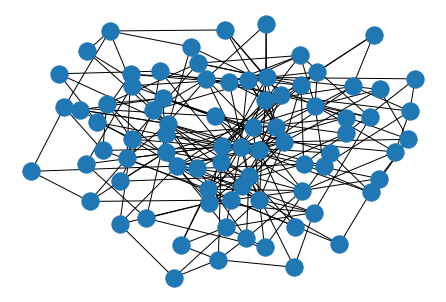

In [70]:
G=model_a(5,80,3)
nx.draw(G)

In [379]:
# todo
ma_graphs = [] 
for i in range (50):
    ma_graphs.append(model_a(5,80,3))
    


In [385]:
sum_a=[]
ga=ma_graphs[0]
for j in range(len(ga.nodes())):
    #print(len(g.nodes()))
    #print(g.degree())
    for g in ma_graphs:
        sa=[]
        sa.append(g.degree(j))


(array([37.,  7., 17.,  3.,  7.,  2.,  5.,  1.,  0.,  1.]),
 array([ 3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. , 16.5, 18. ]),
 <a list of 10 Patch objects>)

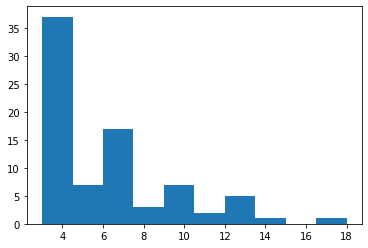

In [384]:
import matplotlib.pyplot as plt
plt.hist(sum_a)

In [341]:
def model_b(m, v):
    G = nx.Graph()
    
    G.add_nodes_from(range(v))
    for i in range (v):
        degree_values = [z+1 for k, z in G.degree()]
        sum_of_degrees = sum(degree_values)
        proba=[]

        for j in G.nodes():
            proba.append((G.degree(j)+1)/sum_of_degrees)
        nodes=[list(a) for a in zip(np.random.choice(list(G.nodes()), p=proba, size=v, replace=False), \
                       np.random.choice(list(G.nodes()), p=proba, size=v, replace = False))]

        #print('noda',nodes)
        for x in range(0,len(degree_values)):
            G.add_edge(nodes[x][0],nodes[x][1])
       
    return G

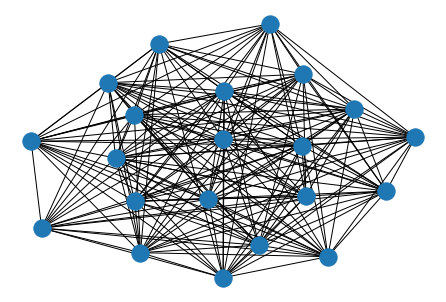

In [375]:
G=model_b(80,21) 
#generate_model_B(21,80)
nx.draw(G)

In [178]:
G.degree()
Gs.degree()

DegreeView({0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, (18, 6): 1, (17, 19): 1, (6, 14): 1, ((17, 19), 7): 1, (15, 2): 1, (19, 20): 1, (17, 18): 1, ((19, 20), 9): 1, ((18, 6), (19, 20)): 1, (13, 12): 1, (((18, 6), (19, 20)), 4): 1, (20, 18): 1, (1, 17): 1, (((17, 19), 7), 4): 1, (1, (15, 2)): 1, (10, ((19, 20), 9)): 1, ((17, 19), 16): 1, (0, (17, 19)): 1, ((17, 19), (10, ((19, 20), 9))): 1, (((17, 19), 7), (10, ((19, 20), 9))): 1, (0, (15, 2)): 1, ((15, 2), (((17, 19), 7), (10, ((19, 20), 9)))): 1, (((18, 6), (19, 20)), (0, (15, 2))): 1, (7, ((17, 19), (10, ((19, 20), 9)))): 1, ((((17, 19), 7), (10, ((19, 20), 9))), (0, (17, 19))): 1, ((7, ((17, 19), (10, ((19, 20), 9)))), ((17, 19), 16)): 1, (0, ((17, 19), (10, ((19, 20), 9)))): 1, (10, (((18, 6), (19, 20)), (0, (15, 2)))): 1, (((((17, 19), 7), (10, ((19, 20), 9))), (0, (17, 19))), (1, 17)): 1, ((((18, 6), (19, 20)), (0, (15, 2))), ((((17, 19

In [356]:
#todo

mb_graphs = [] 
for i in range (50):
    mb_graphs.append(model_b(80,21))

In [156]:
type(mb_graphs[0])

networkx.classes.graph.Graph

In [373]:
#data for visualisation
sum_b=[]
gg=mb_graphs[0]
for j in range(len(gg.nodes())):
    #print(len(g.nodes()))
    #print(g.degree())
    for g in mb_graphs:
        sb=[]
        sb.append(g.degree(j))
    sum_b.append(np.mean(sb))
sum_b

[19.0,
 19.0,
 20.0,
 19.0,
 19.0,
 19.0,
 22.0,
 20.0,
 18.0,
 18.0,
 17.0,
 18.0,
 17.0,
 19.0,
 18.0,
 20.0,
 20.0,
 20.0,
 20.0,
 17.0,
 19.0]

(array([3., 0., 4., 0., 7., 0., 6., 0., 0., 1.]),
 array([17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. ]),
 <a list of 10 Patch objects>)

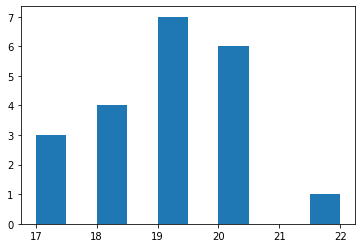

In [377]:
plt.hist(sum_b)

In [230]:
ba = nx.barabasi_albert_graph(20, 5)
G = nx.Graph()
G.add_nodes_from(range(21))

In [235]:

degree_values = [v for k, v in G.degree()]
sum(degree_values)
sum_of_degrees = dict(G.degree()).values()
sum(sum_of_degrees)
#ba.degree()
#DegreeView({0: 8, 1: 4, 2: 5, 3: 10, 4: 8, 5: 17, 6: 12, 7: 11, 8:
#9, 9: 8, 10: 7, 11: 6, 12: 5, 13: 5, 14: 6, 15: 7, 16: 7, 17: 5, 18: 5, 19: 5})
#[8, 4, 5, 10, 8, 17, 12, 11, 9, 8, 7, 6, 5, 5, 6, 7, 7, 5, 5, 5]
# len(degree_values)
# node_probabilities = [(1+G.degree(n))/(sum(degree_values) + len(G.nodes)) for n in G.nodes()]
# #node_probabilities
# for j in G.nodes():
#     proba= (G.degree(j)+1)/len(degree_values)
# #np.random.choice(list(G.nodes()), p=proba, size=6)
# proba

0

In [72]:
G=nx.complete_graph(5)
print(G.nodes())
random.choices(list(G.nodes()), k=4)

[0, 1, 2, 3, 4]


[2, 2, 1, 3]

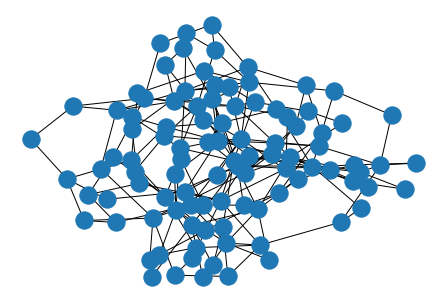

In [51]:
nx.draw(G)

# Projekt opis grafu

W przeciwieństwie do omawianego na wykładzie szerzej grafu ..........G n,p graf ........Gn,e nie opisujemy grafu za pomocą liczby wierzchołków i prawdopodobieństwa, że krawędź między lsoowymi dwoma wierzchołkami będzie istnieć, ale za pomocą wierzchołków i z góry określonej liczby krawędzi. Takie podejście generuje pewną niejednoznaczność - generowana jest cała rodzina grafów o takich parametrach. Dopiero z nich można wylosować jeden konkretny. Mówiąc konkretnie opis grafu za pomocą liczby krawędzi i wierzchołków NIE jest precyzyjny. 

Chcąc opisać graf można wyznaczyć funkcję prawdopodobieństwa, że dwa wierzchołki zostaną połączone. Z kombinatoryki wiemy, że rachunek będzie dość prosty: mamy z góry zadaną liczbę krawędzi ......E i wszystkie możliwości połączenia dwóch dowolnych wierzchołków ......n*(n-1)/2 (slajd 13 wykład 5). w związku z tym dysponujemy wzorem ......p=2e/nn-1.

Korzystając z wiedzy z wykładu oraz z rachunku prawdopodobieństwa wiemy, że taki rozkład zbiega do rozkładu Poissona, tak samo jak ............G n,p. Wniosek = oba modele grafów zbiegają do tego samego rozkładu stopni wierzchołków.



In [164]:
import networkx as nx
import random
def conf_model(nodes_list):
    if len(nodes_list)%2 ==0:
        n_len=len(nodes_list)
        G=nx.empty_graph(n_len)
        lst=[]
        for i in G:
            #for j in range(len(nodes_list[i])):
            for j in range(nodes_list[i]):
                lst.append(i)
        while lst:

            if len(lst)>=2:
                r=random.sample(range(len(lst)), 2)

                k=r[0]
                k1=lst[k]
                l=r[1]
                l1=lst[l]

                G.add_edge(k1,l1)

                del lst[k]

                if (k<l):
                    del lst[l-1]
                else:
                    del lst[l]
                
        return(G)
    else:
        print("Liczba wierzchołków nie jest parzysta")


        


In [165]:
a=conf_model([4,4,4,2])

In [169]:
a.size()

6

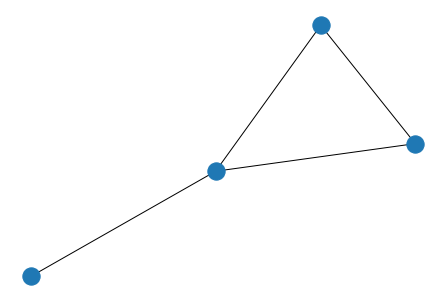

In [166]:
nx.draw(a)

In [167]:
b=conf_model([1,4,4,4,2])

Liczba wierzchołków nie jest parzysta


Zaimplementowana funkcja ma poważną wadę, w wyniku losowania mogą zostać wylosowane dwie obserwacje z tego samego wierzchołka

# BA usuń

## może parę ćwiczeń?

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

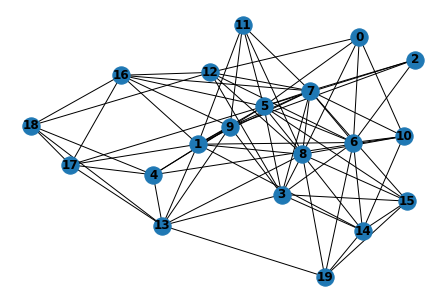

In [5]:

ba = nx.barabasi_albert_graph(20, 5)
nx.draw(ba, pos=None, with_labels=True, font_weight='bold')

# Średni stopień

In [25]:
abc=nx.average_degree_connectivity(ba, weight='weight')
abc
np.array(list(abc.values())).mean()

8.625843253968252

# korelacja 

In [29]:
nx.degree_pearson_correlation_coefficient(ba)

-0.15174542863927812

# Gronowanie

In [98]:
# 3 x liczba trójkątów / liczba dróg o długości 2

trojkaty = nx.triangles(ba, nodes=None)
list(trojkaty.values())



def findPaths(G,u,n):
    if n==0:
        return [[u]]
    paths = [[u]+path for neighbor in G.neighbors(u) for path in findPaths(G,neighbor,n-1) if u not in path]
    return paths

allpaths = []
for node in ba:
    allpaths.extend(findPaths(ba,node,2))
    
len(allpaths)

1098

In [172]:
# length=nx.all_pairs_dijkstra_path_length(ba)
# length=list(length)
# # vert=length[0][1].values()
# # filtered_numbers = [i for i in vert if i ==2 ]
# # filtered_numbers

# filtered=0
# for i in range(len(length)):
#     vert=length[i][1].values()
#     #print(len([i for i in vert if i ==2 ]))
#     filtered =filtered+ len([i for i in vert if i ==2 ])
# filtered

licznik=0
for i in ba.nodes:
    for j in ba.nodes:
        if i!=j:
            licznik=licznik+len((list(nx.all_simple_paths(ba, i, j, 2))))
licznik

1248

In [170]:
3*sum(nx.triangles(ba).values())/(licznik)

0.5769230769230769

# pośrednictwa

In [183]:
licz=list(nx.betweenness_centrality(ba).values())
w1=sum(licz)/len(licz)
w1

licz2=list(nx.edge_betweenness_centrality(ba).values())
w2=sum(licz2)/len(licz2)
w2

0.021824561403508767

# miary małości śwaitów

# efektywność

In [185]:
nx.global_efficiency(ba)

0.6921052631578949

# średnia odległosć

In [152]:
nx.average_shortest_path_length(ba)

1.6368421052631579

# tu dejtafrem

In [184]:
#xd

In [108]:
length=nx.all_pairs_dijkstra_path_length(g)
length=list(length)
# vert=length[0][1].values()
# filtered_numbers = [i for i in vert if i ==2 ]
# filtered_numbers

filtered=0
for i in range(len(length)):
    vert=length[i][1].values()
    filtered =filtered+ len([i for i in vert if i ==2 ])
#length[i][1].values()
filtered

8

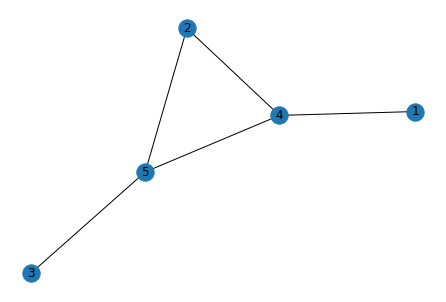

0.5625

In [95]:
g = nx.Graph()
g.add_nodes_from([1,2, 3, 4, 5])
g.add_edges_from([(1,4), (2,4), (2,5), (3,5), (4,5)])

nx.draw(g, with_labels=True)
plt.show()




In [113]:
sum(nx.triangles(g).values())/((filtered))

0.375